In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!ls "/content/drive/MyDrive/DeepLearning/Common Literacy"

CL_Bert_Base_Uncased.ipynb
CL_CNN_BiLSTM_Glove100d_TFIDF.ipynb
CL_CNN_Glove_FastText_300d_AvgW2V_TFIDF.ipynb
CL_CNN_Model.ipynb
CL_Elmo.ipynb
CL_Flair.ipynb
CL_Glove100d_AVGW2V_POS.ipynb
CL_Glove100d_AVGW2V_TFIDFAVGW2V_POS.ipynb
CL_Glove100d_BOW_TFIDF_AvgW2V.ipynb
CL_Glove100d_BOW_TFIDF_AvgW2V_SVD.ipynb
CL_Glove300d_BOW_TFIDF_AVGW2V.ipynb
CL_Glove_FastText_300d_AVGW2V_POS.ipynb
Dataset
FastText
GloveVector


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm

from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from mlxtend.regressor import StackingRegressor

# Gensim Models word2vec
import gensim
from gensim.models import Word2Vec
%matplotlib inline

In [4]:
train ='/content/drive/MyDrive/DeepLearning/Common Literacy/Dataset/train.csv'
test = '/content/drive/MyDrive/DeepLearning/Common Literacy/Dataset/test.csv'

In [5]:
df_train = pd.read_csv(train)
df_test = pd.read_csv(test)

In [6]:
print("This is train dataset")
print(df_train.head(2))
print(df_train.columns)
print("="*100)
print("This is test dataset")
print(df_test.head(2))
print(df_test.columns)

This is train dataset
          id url_legal  ...    target standard_error
0  c12129c31       NaN  ... -0.340259       0.464009
1  85aa80a4c       NaN  ... -0.315372       0.480805

[2 rows x 6 columns]
Index(['id', 'url_legal', 'license', 'excerpt', 'target', 'standard_error'], dtype='object')
This is test dataset
          id  ...                                            excerpt
0  c0f722661  ...  My hope lay in Jack's promise that he would ke...
1  f0953f0a5  ...  Dotty continued to go to Mrs. Gray's every nig...

[2 rows x 4 columns]
Index(['id', 'url_legal', 'license', 'excerpt'], dtype='object')


### Cleaning the text data for any special characters and numerical characters

In [7]:
# importing stopwords from nltk library
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
stopword = stopwords.words('english')
print(stopword)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over',

In [8]:
def testpreprocess(phrase):
    phrase = re.sub('[^A-Za-z0-9]+', ' ', phrase)
    phrase = re.sub(r'\w*\d\w*', '', phrase).strip()
    return phrase

In [9]:
preprocessed_excerpt = []
for sentence in tqdm(df_train['excerpt'].values):
  sent = testpreprocess(sentence)
  sent = sent.lower().strip()
  # sent = ' '.join(e for e in sent.split(" ") if e not in stopword)
  preprocessed_excerpt.append(sent)

df_train['cleaned_excerpt'] = preprocessed_excerpt

100%|██████████| 2834/2834 [00:00<00:00, 7033.73it/s]


In [10]:
print(df_train['excerpt'].values[0])
print("="*100)
print(df_train['cleaned_excerpt'].values[0])

When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.
The floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.
At each end of the room, on the wall, hung a beautiful bear-skin rug.
These rugs were for prizes, one for the girls and one for the boys. And this was the game.
The girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.
This would have been an easy matter, but each traveller was obliged to wear snowshoes.
when th

### Flair Word Embedding Trainings

In [11]:
# !pip install flair

In [13]:
#https://www.geeksforgeeks.org/flair-a-framework-for-nlp/#:~:text=Flair%20supports%20a%20number%20of,is%20used%20for%20Sequence%20Labelling.

import flair
from flair.data import Sentence
from flair.embeddings import WordEmbeddings
  
# using glove embedding
GloVe_embedding = WordEmbeddings('glove')
  
# input a  sentence
s = Sentence('Geeks for Geeks helps me study.')
  
# embed the sentence
GloVe_embedding.embed(s)

2021-07-22 17:01:10,904 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim.vectors.npy not found in cache, downloading to /tmp/tmphf6gzjcv


100%|██████████| 160000128/160000128 [00:19<00:00, 8155929.51B/s] 

2021-07-22 17:01:31,359 copying /tmp/tmphf6gzjcv to cache at /root/.flair/embeddings/glove.gensim.vectors.npy


2021-07-22 17:01:31,514 removing temp file /tmp/tmphf6gzjcv
2021-07-22 17:01:33,602 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim not found in cache, downloading to /tmp/tmpzhqq2g94


100%|██████████| 21494764/21494764 [00:04<00:00, 4683573.14B/s]

2021-07-22 17:01:39,023 copying /tmp/tmpzhqq2g94 to cache at /root/.flair/embeddings/glove.gensim
2021-07-22 17:01:39,048 removing temp file /tmp/tmpzhqq2g94


Token: 1 Geeks
tensor([ 0.2142,  0.2960,  0.9643, -1.4674, -0.6411,  0.2331,  0.2424, -0.0383,
         0.0438,  0.3449,  0.6657, -0.6505,  0.4983, -0.1760, -0.0303,  0.1394,
         0.5771,  0.7102, -0.1414,  0.5078, -0.1578, -0.4464,  0.2313, -0.5030,
         0.7759,  0.3449, -0.0165,  0.9257, -0.5512, -0.6637,  0.0623, -0.2787,
        -0.3560, -0.0842,  0.2933,  0.5622, -0.1808, -0.4723,  0.5207, -0.2919,
        -0.4536,  0.8259, -1.0018, -0.4253, -0.3070, -0.8393, -0.2085,  0.9410,
         0.0317,  0.0324, -0.5611, -0.2915, -0.2913, -0.0548, -0.4060,  0.3418,
         0.1945,  0.1937,  0.1153, -0.1320,  0.1911,  0.0536, -0.6486, -0.5467,
        -0.3020,  0.6399,  1.0721,  0.1090,  0.1737,  0.1064,  0.0605,  0.3288,
        -0.4029,  0.0628, -1.5819,  0.0145,  0.2789, -0.3618,  0.5132, -0.4850,
        -0.1998, -0.2059, -0.4245,  0.6228, -0.5922, -0.0412, -0.7437, -0.3015,
        -0.8668, -0.3022, -0.2867,  0.4423,  0.0697, -0.3668, -0.4350, -0.4438,
        -0.0041, -0.4083,

In [15]:
# print the embedded tokens
for token in s:
    print(token)
    wordembed = token.embedding
    print(wordembed.shape)

Token: 1 Geeks
torch.Size([100])
Token: 2 for
torch.Size([100])
Token: 3 Geeks
torch.Size([100])
Token: 4 helps
torch.Size([100])
Token: 5 me
torch.Size([100])
Token: 6 study
torch.Size([100])
Token: 7 .
torch.Size([100])


In [16]:
from flair.embeddings import FlairEmbeddings
  
# using forward flair embeddingembedding
forward_flair_embedding= FlairEmbeddings('news-forward-fast')
  
# input the sentence
s = Sentence('Geeks for Geeks helps me study.')
  
# embed words in the input sentence
forward_flair_embedding.embed(s)

2021-07-22 17:05:18,881 https://flair.informatik.hu-berlin.de/resources/embeddings/flair/lm-news-english-forward-1024-v0.2rc.pt not found in cache, downloading to /tmp/tmp05rl5e91


100%|██████████| 19689779/19689779 [00:04<00:00, 4573177.80B/s]

2021-07-22 17:05:24,015 copying /tmp/tmp05rl5e91 to cache at /root/.flair/embeddings/lm-news-english-forward-1024-v0.2rc.pt
2021-07-22 17:05:24,039 removing temp file /tmp/tmp05rl5e91


[Sentence: "Geeks for Geeks helps me study ."   [− Tokens: 7]]

In [23]:
# print the embedded tokens
for token in s:
    print(token)
    wordembed = token.embedding
    word_array = wordembed.cpu().detach().numpy() # used to convert a torch tensor to numpy array
    print(word_array.shape)

Token: 1 Geeks
(1024,)
Token: 2 for
(1024,)
Token: 3 Geeks
(1024,)
Token: 4 helps
(1024,)
Token: 5 me
(1024,)
Token: 6 study
(1024,)
Token: 7 .
(1024,)


### Average Flair Embedding

In [38]:
d_model = 1024


def average_flair_embedding(df):
  forward_flair_embedding= FlairEmbeddings('news-forward-fast')

  empty_list = []
  for sent in tqdm(df):
    cnt_words = 0
    s = Sentence(sent)
    forward_flair_embedding.embed(s)
    vector = np.empty(d_model,dtype=float)
    for word in s:
      wordembed = token.embedding
      word_vector = wordembed.cpu().detach().numpy()
      vector += word_vector
      cnt_words += 1
    if cnt_words != 0:
      vector /= cnt_words
    empty_list.append(vector)
  flair_array = np.stack(empty_list, axis=0)
  return flair_array

### Average Flair Embedding with Positional Encoding

In [50]:
def positionalEncoding2d(max_sentence_length,d_model):
  positional_embeddings = np.zeros((max_sentence_length, d_model))
  for position in range(max_sentence_length):
      for i in range(0, d_model, 2):
        positional_embeddings[position, i] = (np.sin(position/(10000 ** ((2*i) / d_model))))
        positional_embeddings[position, i + 1] = (np.cos(position/(10000 ** ((2*(i+1)) / d_model))))
  return positional_embeddings

def average_flair_embedding_pos(df):
  forward_flair_embedding= FlairEmbeddings('news-forward-fast')

  empty_list = []
  for sent in tqdm(df):
    len_sent = sent.split()
    max_sentence_length = len(len_sent)
    empty_vector = np.empty((0,d_model),dtype=float)
    posEmbed = positionalEncoding2d(max_sentence_length,d_model)
    s = Sentence(sent)
    forward_flair_embedding.embed(s)
    for word in s:
      wordembed = token.embedding
      word_vector = wordembed.cpu().detach().numpy()
      vectorTranspose = np.reshape(word_vector,(-1,d_model))
      empty_vector = np.append(empty_vector,vectorTranspose,axis=0)

    WordEmbedPOS = np.add(posEmbed, empty_vector)
    WordEmbedPOSColSum  = WordEmbedPOS.sum(axis=0)
    WordEmbedPOSColSum /= max_sentence_length
    empty_list.append(WordEmbedPOSColSum)
  flair_array = np.stack(empty_list, axis=0)
  return flair_array

In [ ]:
def flair_embedding(df):
  forward_flair_embedding= FlairEmbeddings('news-forward-fast')

  empty_list = []
  for sent in df:
    s = Sentence(sent)
    forward_flair_embedding.embed(s)
    empty_vector = np.empty((0,d_model),dtype=float)
    for word in s:
      wordembed = token.embedding
      word_vector = wordembed.cpu().detach().numpy()
      vectorTranspose = np.reshape(word_vector,(-1,d_model))
      print("This is Transpose Shape",vectorTranspose.shape)
      empty_vector = np.append(empty_vector,vectorTranspose,axis=0)
    empty_list.append(empty_vector)
  # flair_array = np.stack(empty_list, axis=0)
  return empty_list

In [26]:
# x = df_train['cleaned_excerpt'][0:5]
# print(x)

0    when the young people returned to the ballroom...
1    all through dinner time mrs fayre was somewhat...
2    as roger had predicted the snow departed as qu...
3    and outside before the palace a great garden w...
4    once upon a time there were three bears who li...
Name: cleaned_excerpt, dtype: object


In [39]:
word_embed = average_flair_embedding(x)

In [41]:
print(word_embed.shape)

(5, 1024)


### Splitting data into Train and cross validation(or test): Stratified Sampling


In [42]:
Y = df_train['target']
X = df_train['cleaned_excerpt']

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)

In [44]:
print(X_train.head(5))

639     imagine a person who has fallen into a coma a ...
1011    goat said ehe pig come with me to my house we ...
2174    thus it was that we lived all alone knowing no...
1973    she carried the kitten into the kitchen and so...
1125    i know that many people are worrying about sta...
Name: cleaned_excerpt, dtype: object


### Flair Word Embedding

In [45]:
X_train_excerpt_flair = average_flair_embedding(X_train)
X_test_excerpt_flair = average_flair_embedding(X_test)

print("="*100)
print("After vectorizations")
print("="*50)
print(X_train_excerpt_flair.shape, Y_train.shape)
print(X_test_excerpt_flair.shape, Y_test.shape)
print("="*100)

After vectorizations
(1898, 1024) (1898,)
(936, 1024) (936,)


### Flair Embedding with Positional Encoding

In [51]:
X_train_excerpt_flair_pos = average_flair_embedding_pos(X_train)
X_test_excerpt_flair_pos = average_flair_embedding_pos(X_test)

print("="*100)
print("After vectorizations")
print("="*50)
print(X_train_excerpt_flair_pos.shape, Y_train.shape)
print(X_test_excerpt_flair_pos.shape, Y_test.shape)
print("="*100)

100%|██████████| 936/936 [05:03<00:00,  3.09it/s]

After vectorizations
(1898, 1024) (1898,)
(936, 1024) (936,)


In [65]:
print(X_train_excerpt_flair_pos[0])
print(X_train_excerpt_flair_pos[1])
print(X_train_excerpt_flair_pos[2])

[ 8.86102309e-03  9.62742380e-03  4.42948195e-03 ...  9.99999991e-01
 -5.02359997e-06  1.00144460e+00]
[ 8.44417416e-03 -2.84551856e-03  5.31358217e-03 ...  9.99999991e-01
 -4.87328820e-06  1.00144460e+00]
[ 4.78157308e-04 -3.88095799e-04  4.04045978e-03 ...  9.99999991e-01
 -5.11171377e-06  1.00144460e+00]


# Various Models

In [56]:
# data = {"Bag of Words":(X_train_excerpt_bow,X_test_excerpt_bow),"TF-IDF":(X_train_excerpt_tfidf,X_test_excerpt_tfidf),"Avg Word2Vec":(X_train_excerpt_avgw2v,X_test_excerpt_avgw2v)}
data = {"Flair Embedding POS":(X_train_excerpt_flair_pos,X_test_excerpt_flair_pos),"Flair Embedding":(X_train_excerpt_flair,X_test_excerpt_flair)}

### Function to run all models together

In [57]:
def modelfunction(modelname,data,Y_train,Y_test,param):
  for key,value in tqdm(data.items()):
    train = value[0]
    test = value[1]
    gscv = GridSearchCV(modelname, param_grid=param,cv=5,verbose=10,n_jobs=-1)
    results = gscv.fit(train, Y_train)
    best_estimate = gscv.best_estimator_

    Y_pred_train = best_estimate.predict(train)
    train_residuals = Y_train - Y_pred_train
    Y_pred_test = best_estimate.predict(test)
    test_residuals = Y_test - Y_pred_test
    mse_train = metrics.mean_squared_error(Y_train,Y_pred_train)
    mse_test = metrics.mean_squared_error(Y_test,Y_pred_test)

    print("-"*100)
    print("The model is run on {}: ".format(key))
    print("="*100)
    print(best_estimate)
    print("*"*50)
    print("Root Mean squared Error Train for {}: ".format(key), np.sqrt(mse_train))
    print("Root Mean squared Error Test for {}: ".format(key), np.sqrt(mse_test))

    plt.subplot(1,2,1)
    plt.scatter(train_residuals.index,train_residuals)
    plt.title("Train Error Plot")
    plt.xlabel('Index')
    plt.ylabel('Actual - Predicted')

    plt.subplot(1,2,2)
    plt.scatter(test_residuals.index,test_residuals)
    plt.title("Test Error Plot")
    plt.xlabel('Index')
    plt.ylabel('Actual - Predicted')
    plt.show()

### Lasso Regression

  0%|          | 0/2 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    4.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    4.7s finished


----------------------------------------------------------------------------------------------------
The model is run on Flair Embedding POS: 
Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
**************************************************
Root Mean squared Error Train for Flair Embedding POS:  1.0382158851285095
Root Mean squared Error Test for Flair Embedding POS:  1.0031583034298426


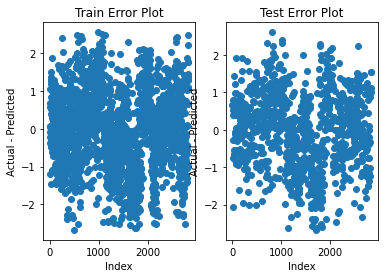

 50%|█████     | 1/2 [00:05<00:05,  5.56s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0519s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1397s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.5s finished


----------------------------------------------------------------------------------------------------
The model is run on Flair Embedding: 
Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
**************************************************
Root Mean squared Error Train for Flair Embedding:  1.0435305880295698
Root Mean squared Error Test for Flair Embedding:  1.0125746107498654


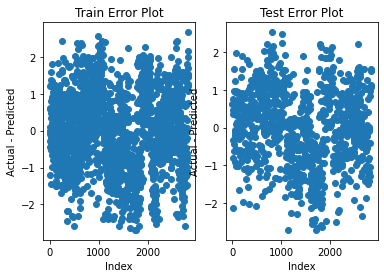

100%|██████████| 2/2 [00:06<00:00,  3.23s/it]


In [58]:
lasso_params = {'alpha':[0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]}
lasso = Lasso()

modelfunction(lasso,data,Y_train,Y_test,lasso_params)

  0%|          | 0/2 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done  43 out of  45 | elapsed:   47.8s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   50.6s finished


----------------------------------------------------------------------------------------------------
The model is run on Flair Embedding POS: 
SVR(C=80, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
**************************************************
Root Mean squared Error Train for Flair Embedding POS:  1.038125936680109
Root Mean squared Error Test for Flair Embedding POS:  1.0046488521340005


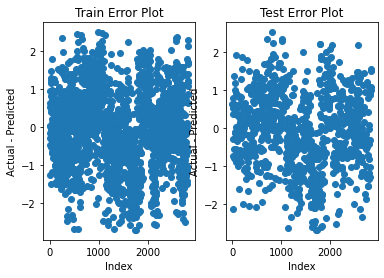

 50%|█████     | 1/2 [01:03<01:03, 63.07s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done  43 out of  45 | elapsed:   47.5s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   50.4s finished


----------------------------------------------------------------------------------------------------
The model is run on Flair Embedding: 
SVR(C=700, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
**************************************************
Root Mean squared Error Train for Flair Embedding:  1.0416575053777384
Root Mean squared Error Test for Flair Embedding:  1.009537435222735


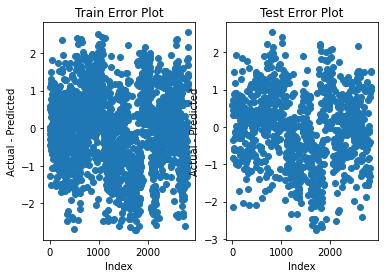

100%|██████████| 2/2 [02:05<00:00, 62.83s/it]


In [59]:
SVR_params = {'C':[80,100,150,200,300,400,500,600,700]}
RBF_SVR = SVR(kernel='rbf',gamma="scale")

modelfunction(RBF_SVR,data,Y_train,Y_test,SVR_params)

Number of components = 0 and explained variance = 0.0
Number of components = 1 and explained variance = 0.0046227634587975
Number of components = 2 and explained variance = 0.864232823156469
Number of components = 3 and explained variance = 0.949168081285275
Number of components = 4 and explained variance = 0.9735205983902772
Number of components = 5 and explained variance = 0.9833579434387082
Number of components = 6 and explained variance = 0.9885313925988182
Number of components = 7 and explained variance = 0.9915399204520443
Number of components = 8 and explained variance = 0.9935805603091403
Number of components = 9 and explained variance = 0.9951295489542248
Number of components = 10 and explained variance = 0.9962680540054253
Number of components = 11 and explained variance = 0.9972322557774048
Number of components = 12 and explained variance = 0.9979032603960776
Number of components = 13 and explained variance = 0.9984375649398861
Number of components = 14 and explained varianc

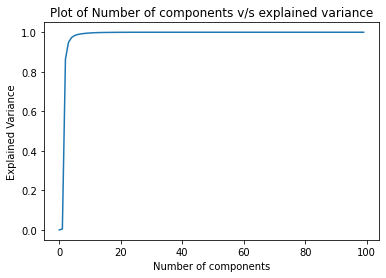

In [62]:
# Program to find the optimal number of components for Truncated SVD
n_comp = range(0, 100, 1) # list containing different values of components
explained = [] # explained variance ratio for each component of Truncated SVD
for x in n_comp:
    svd = TruncatedSVD(n_components=x)
    svd.fit(X_train_excerpt_flair_pos)
    explained.append(svd.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))
plt.plot(n_comp, explained)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()